# Imports

In [1]:
import tempfile
import os
import glob
from tqdm import tqdm

import tensorflow as tf
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, models

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# GPU Setup

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading the Finetuned Network

In [4]:
new_model = tf.keras.models.load_model('pretrained-model/inceptionv3-finetuned/')
# Check its architecture
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                88107     
Total params: 21,890,891
Trainable params: 21,856,459
Non-trainable params: 34,432
_________________________________________________________________


Found 12630 files belonging to 43 classes.
395/395 [==============================] - 78s 197ms/step - loss: 22.7564 - accuracy: 0.1592


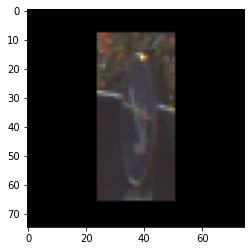

In [7]:
sevendir = './pretrained-model-data/testfolders75/'

seventest_ds = tf.keras.preprocessing.image_dataset_from_directory(
    sevendir, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(75,
    75), shuffle=True, seed=42,
)
test_loss, test_acc = new_model.evaluate(seventest_ds, verbose=1)

get = next(iter(seventest_ds))
plt.imshow(get[0][0].numpy().astype("uint8"))

## Reading Images from filesystem

In [60]:
def readTrainTestImages(trainpath,testpath):
    from tqdm import tqdm
    import matplotlib.image as mpimg
    trainImages = []
    testImages = []
    trainimgfiles = glob.glob(trainpath + '**//*.png')
    testimgfiles = glob.glob(testpath + '**//*.png')
    trainimgfiles = sorted(trainimgfiles, key=lambda x: int(x.split("\\")[2].split(".")[0]))
    testimgfiles = sorted(testimgfiles, key=lambda x: int(x.split("\\")[2].split(".")[0]))
    print(testimgfiles[:5])
    for i in tqdm(range(len(trainimgfiles))):
        # Read Images
#         print(trainimgfiles[i])
        img = mpimg.imread(trainimgfiles[i])   
        trainImages.append(img)        
    print('read ' + str(i) + " training images")   
    
    for i in tqdm(range(len(testimgfiles))):
        # Read Images
#         print(testimgfiles[i])
        img = mpimg.imread(testimgfiles[i])   
        testImages.append(img)        
    print(f'read {i} test images')
            
    
    trainImages = np.array(trainImages, dtype='float32')
    testImages = np.array(testImages, dtype='float32')
    
    trainlabels = pd.read_csv(trainpath + '/trainlabels.csv',index_col=False)
    testlabels = pd.read_csv(testpath + '/testlabels.csv',index_col=False)
    trainlabels.drop(trainlabels.columns[0], axis=1, inplace=True)
    testlabels.drop(testlabels.columns[0], axis=1, inplace=True)
    
    return trainImages, trainlabels, testImages, testlabels
#     return trainimgfiles, testimgfiles
    

In [67]:
trainpath = './pretrained-model-data/trainfolders75/'
testpath = './pretrained-model-data/testfolders75/'
trainData, trainLabels, testData, testLabels = readTrainTestImages(trainpath,testpath)

  0%|                                                            | 10/39209 [00:00<06:36, 98.86it/s]

['./pretrained-model-data/testfolders75\\16\\0.png', './pretrained-model-data/testfolders75\\1\\1.png', './pretrained-model-data/testfolders75\\38\\2.png', './pretrained-model-data/testfolders75\\33\\3.png', './pretrained-model-data/testfolders75\\11\\4.png']


  0%|                                                             | 1/12630 [00:00<24:49,  8.48it/s]

read 39208 training images


100%|█████████████████████████████████████████████████████████| 12630/12630 [08:15<00:00, 25.51it/s]


read 12629 test images


In [61]:
# trainpath = './pretrained-model-data/trainfolders75/'
# testpath = './pretrained-model-data/testfolders75/'
# trainData1, trainLabels1, testData1, testLabels1 = readTrainTestImages(trainpath,testpath)

  0%|▏                                                         | 135/39209 [00:00<00:57, 676.58it/s]

['./pretrained-model-data/testfolders75\\16\\0.png', './pretrained-model-data/testfolders75\\1\\1.png', './pretrained-model-data/testfolders75\\38\\2.png', './pretrained-model-data/testfolders75\\33\\3.png', './pretrained-model-data/testfolders75\\11\\4.png']


  0%|▏                                                          | 32/12630 [00:00<00:42, 293.59it/s]

read 39208 training images


100%|████████████████████████████████████████████████████████| 12630/12630 [00:41<00:00, 306.09it/s]


read 12629 test images


In [21]:
# Download class names
# wget "https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv" -outfile "signnames.csv"
classes = pd.read_csv('signnames.csv')
class_names = {}
for i, row in classes.iterrows():
    class_names[str(row[0])] = row[1]
    
class_names

{'0': 'Speed limit (20km/h)',
 '1': 'Speed limit (30km/h)',
 '2': 'Speed limit (50km/h)',
 '3': 'Speed limit (60km/h)',
 '4': 'Speed limit (70km/h)',
 '5': 'Speed limit (80km/h)',
 '6': 'End of speed limit (80km/h)',
 '7': 'Speed limit (100km/h)',
 '8': 'Speed limit (120km/h)',
 '9': 'No passing',
 '10': 'No passing for vehicles over 3.5 metric tons',
 '11': 'Right-of-way at the next intersection',
 '12': 'Priority road',
 '13': 'Yield',
 '14': 'Stop',
 '15': 'No vechiles',
 '16': 'Vehicles over 3.5 metric tons prohibited',
 '17': 'No entry',
 '18': 'General caution',
 '19': 'Dangerous curve to the left',
 '20': 'Dangerous curve to the right',
 '21': 'Double curve',
 '22': 'Bumpy road',
 '23': 'Slippery road',
 '24': 'Road narrows on the right',
 '25': 'Road work',
 '26': 'Traffic signals',
 '27': 'Pedestrians',
 '28': 'Children crossing',
 '29': 'Bicycles crossing',
 '30': 'Beware of ice/snow',
 '31': 'Wild animals crossing',
 '32': 'End of all speed and passing limits',
 '33': 'Turn 

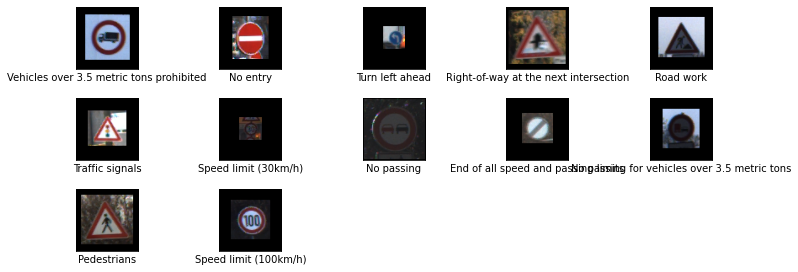

In [68]:
plot = 1

plt.figure(figsize=(10,10))
for i in range(0,12000,1000):
    plt.subplot(8,5,plot)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testData[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[str(testLabels.iloc[i]['Class'])])
    plot += 1
plt.show()

In [73]:
test_loss, test_acc = new_model.evaluate(testData,testLabels, verbose=1)

395/395 - 7s - loss: 4.0977 - accuracy: 0.0239


In [70]:
np.argmax(new_model.predict(testData[0].reshape(-1,75,75,3)))

35

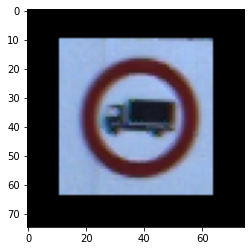

In [96]:
plt.imshow(testData[0])

In [99]:
testData[0].shape, testData[0].dtype, type(testData)

((75, 75, 3), dtype('float32'), numpy.ndarray)

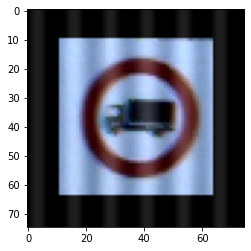

In [101]:
plt.imshow(get_periodic_noise(testData[0].astype('uint8')))

### Adding Gaussian Noise

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
testLayer = layers.GaussianNoise(5, input_shape=(-1,40,40,-1),dtype=tf.float32) #50
testLayer()

[<tf.Tensor: shape=(), dtype=float32, numpy=1.1>,
 <tf.Tensor: shape=(), dtype=int32, numpy=2>,
 <tf.Tensor: shape=(), dtype=int32, numpy=3>,
 <tf.Tensor: shape=(), dtype=int32, numpy=4>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>]

### Adding Salt and Pepper Noise!

In [9]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
#     print(len(X_imgs_copy))
    row, col, ch = X_imgs_copy.shape
#     print('=====> ', row, col, ch)
    salt_vs_pepper = 0.5
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy.size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy.size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
#         print("coords", coords)
        X_img[coords[0], coords[1]] = 1

 

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1]] = 0
    return X_imgs_copy
  
 

### Adding Periodic noise

In [10]:
import math

def get_periodic_noise( X_imgs ):
    
    X_imgs_copy = X_imgs.copy()
    row, col, ch = X_imgs_copy.shape
    degree = 0.5
    for i in range(row):
        for j in range(col):
            X_imgs_copy[i, j] = X_imgs[i,j]+ 0.25*(degree * (math.sin(degree*j))) #+ degree * math.cos(degree*j)); #only sine term, sine term into 0.5, sine plus cos term on 0.5
    X_imgs_copy=np.clip(X_imgs_copy, 0, 1)
    return X_imgs_copy

### Greyscaling transforms for GANs

In [11]:
def get_grey_img(img):
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    return imgGray

## Experiment 1: Inception V3

In [91]:
incept100 = tf.keras.models.load_model('pretrained-model/inceptionv3-after100epochs/')
# Check its architecture
incept100.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 43)                88107     
Total params: 21,890,891
Trainable params: 21,856,459
Non-trainable params: 34,432
_________________________________________________________________


In [90]:
testdir = './testfolders/'
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testdir, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(75,
    75), shuffle=True, seed=42,
)

Found 12630 files belonging to 43 classes.


In [92]:
test_loss, test_acc = incept100.evaluate(test_ds, verbose=1)

395/395 [==============================] - 42s 105ms/step - loss: 0.0844 - accuracy: 0.9797- ETA: 4s


In [95]:
np.argmax(incept100.predict(testData[0].reshape(-1,75,75,3)))

42

In [94]:
pred = []
real = []
for i in range(100):
    pred = np.argmax(incept100.predict(testData[i].reshape(-1,75,75,3)))
    real = testLabels.iloc[i]['Class']
    print(pred, real)
    

42 16
42 1
42 38
42 33
42 11
42 38
42 18
42 12
42 25
42 35
42 12
42 7
42 23
42 7
42 4
42 9
42 21
42 20
42 27
42 38
42 4
42 33
42 9
42 3
42 1
42 11
42 13
42 10
42 9
42 11
42 5
42 17
42 34
42 23
42 2
42 17
42 3
42 12
42 16
42 8
42 7
42 30
42 18
42 12
42 24
42 25
42 3
42 10
42 18
42 8
42 25
42 13
42 15
42 9
42 13
42 35
42 5
42 26
42 9
42 16
42 38
42 10
42 4
42 9
42 15
42 9
42 26
42 2
42 5
42 28
42 11
42 25
42 30
42 34
42 5
42 12
42 1
42 10
42 25
42 25
42 21
42 33
42 25
42 7
42 10
42 35
42 3
42 7
42 22
42 13
42 3
42 1
42 2
42 14
42 12
42 32
42 3
42 38
42 9
42 33


## Experiment 2: ResNet50

In [86]:
resnet = tf.keras.models.load_model('pretrained-model/resnet-afterfinetune/')
# Check its architecture
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 43)                88107     
Total params: 23,675,819
Trainable params: 23,622,699
Non-trainable params: 53,120
_________________________________________________________________


In [87]:
test_loss, test_acc = resnet.evaluate(testData,testLabels, verbose=1)

395/395 [==============================] - 8s 20ms/step - loss: 14.7068 - accuracy: 0.0356: 5s - loss: 14.5902 - accuracy: 0. - ETA: 5s - loss: 14.6526 - accu - ETA: 4s - loss: 14.7676 - accurac - ETA: 4s - loss: 14.7119 - accuracy: 0.0 - ETA: 4s - loss: 14.7373 - accuracy: 0.0 - ETA: 3s - loss: 14.7146 -  - ETA: 2s - loss: 14.7308 - accuracy: 0. - ETA: 2s - loss: 14 - ETA: 1s - loss: 14.6810 - accuracy: 0 - ETA: 0s - loss: 14.7037 -  - ETA: 0s - loss: 14.7027 - accuracy: 0.03


In [88]:
np.argmax(resnet.predict(testData[0].reshape(-1,75,75,3)))

7

In [89]:
pred = []
real = []
for i in range(100):
    pred = np.argmax(resnet.predict(testData[i].reshape(-1,75,75,3)))
    real = testLabels.iloc[i]['Class']
    print(pred, real)
    

7 16
7 1
7 38
7 33
7 11
7 38
7 18
7 12
7 25
7 35
7 12
7 7
7 23
7 7
7 4
7 9
7 21
7 20
7 27
7 38
7 4
7 33
7 9
7 3
7 1
7 11
7 13
7 10
7 9
7 11
7 5
7 17
7 34
7 23
7 2
7 17
7 3
7 12
7 16
7 8
7 7
7 30
7 18
7 12
7 24
7 25
7 3
7 10
7 18
7 8
7 25
7 13
7 15
7 9
7 13
7 35
7 5
7 26
7 9
7 16
7 38
7 10
7 4
7 9
7 15
7 9
7 26
7 2
7 5
7 28
7 11
7 25
7 30
7 34
7 5
7 12
7 1
7 10
7 25
7 25
7 21
7 33
7 25
7 7
7 10
7 35
7 3
7 7
7 22
7 13
7 3
7 1
7 2
7 14
7 12
7 32
7 3
7 38
7 9
7 33
